In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl

import vice

from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [4]:
from surp import subgiants
from surp import gce_math as gcem
from surp.gce_math import MH_to_Z, Z_to_MH, Z_SUN
from surp._globals import AGB_MODELS
import surp

import arya

In [5]:
arya.style.set_size((4, 2*np.sqrt(2)))

In [6]:
surp.yields.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 5.28e-02 (Z-Z0),    1.36 × cristallo11             0                              
                    Z>=-1.00e+00; 8.67e-04 +                                                                     
                    0.00e+00 Z, else                                                                             

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



total c yield
agb_model

In [7]:
df = subgiants
filt = ~df["high_alpha"]
subgiants = df[filt].copy() #low alpha is closer to equilibrium

subgiants["C_MG_ERR"] = subgiants["C_FE_ERR"] + subgiants["MG_FE_ERR"]
subgiants["N_MG_ERR"] = subgiants["C_FE_ERR"] + subgiants["N_FE_ERR"]

df_subgiants = subgiants[["C_MG", "MG_H", "C_MG_ERR"]]

all_abundances = pd.read_csv("../notebooks/data_analysis/all_data.csv")
stars = pd.read_csv("../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63], engine="python")
stars["C_MG"] =  stars["[C/H]3N"] - stars["[O/H]3N"]
stars["MG_H"] =  stars["[O/H]3N"]
stars["C_MG_ERR"] = stars["e_[C/H]3N"] + stars["e_[O/H]3N"]

df_stars = stars[["C_MG", "MG_H", "C_MG_ERR"]]

all_abundances["C_MG"] = all_abundances["[c/o]"]
all_abundances["MG_H"] = all_abundances["[o/h]"]
all_abundances["C_MG_ERR"] = all_abundances["[c/o]_err"]

stars_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "star")]
RL_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "RL")]
DLA_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "DLA")]
dwarf_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "dwarf")]

(-0.3, 0.1)

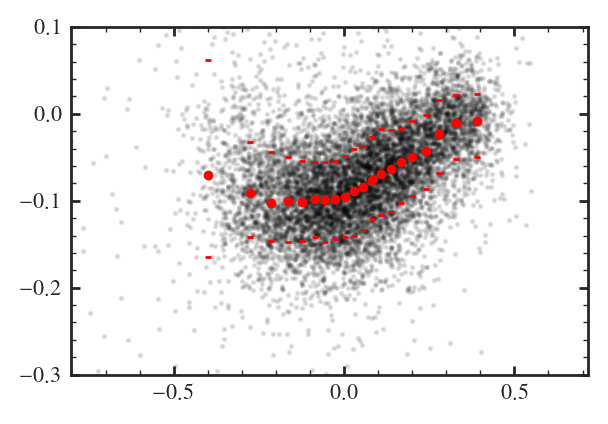

In [8]:
arya.medianplot(subgiants, x="MG_H", y="C_MG", numbins=20, stat="median", color="r", errorbar="pi")
#arya.medianplot(subgiants, x="MG_H", y="C_MG", numbins=20, stat="mean", color="r", errorbar=None)

plt.scatter(subgiants.MG_H, subgiants.C_MG, s=1, color="k", alpha=0.1, zorder=-1)
plt.xlim(-0.8)
plt.ylim(-0.3, 0.1)

Text(0, 0.5, '[c/o]')

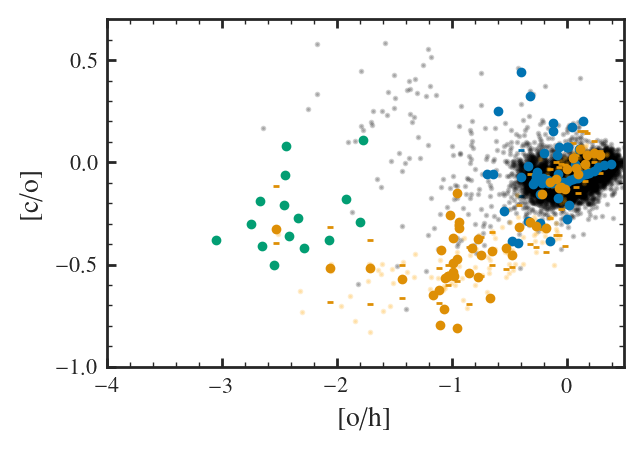

In [9]:
df_s = arya.medianplot(subgiants, x="MG_H", y="C_MG", numbins=20, stat="median", errorbar="pi", zorder=3)
plt.scatter(subgiants.MG_H, subgiants["C_MG"], s=1, color="k", alpha=0.2)

df_a = arya.medianplot(all_abundances, x="MG_H", y="C_MG", binsize=10, stat="median", errorbar="pi", zorder=3)
plt.scatter(df_stars.MG_H, df_stars["C_MG"], s=1, color="orange", alpha=0.2)

MoverH = df_s.data.x
c_o = df_s.data.y
c_o_err = (df_s.data.y_h - df_s.data.y_l)/(df_s.data.counts)**0.5

MoverH_a = df_a.data.x
c_o_a = df_a.data.y
c_o_err_a = (df_a.data.y_h - df_a.data.y_l)/(df_a.data.counts)**0.5
plt.scatter(RL_all.MG_H, RL_all.C_MG)
plt.scatter(dwarf_all.MG_H, dwarf_all.C_MG)
plt.scatter(DLA_all.MG_H, DLA_all.C_MG)




plt.xlim(-4, 0.5)
plt.ylim(-1, 0.7)
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

In [10]:
def y_mod(x, a, b):
    return a*(x-Z_SUN) + b

In [11]:
def co_to_yc(c_o):
    return y_mg_cc * gcem.brak_to_abund(c_o, "C", "Mg")

y_mg_cc = vice.yields.ccsne.settings["mg"]
y_o_cc = vice.yields.ccsne.settings["o"]
y_c_cc = vice.yields.ccsne.settings["c"]


[0.02368623 0.00271175]
[1.5590518e-03 1.4688615e-05]
yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 5.28e-02 (Z-Z0),    1.36 × cristallo11             0                              
                    Z>=-1.00e+00; 8.67e-04 +                                                                     
                    0.00e+00 Z, else                                                                             

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70

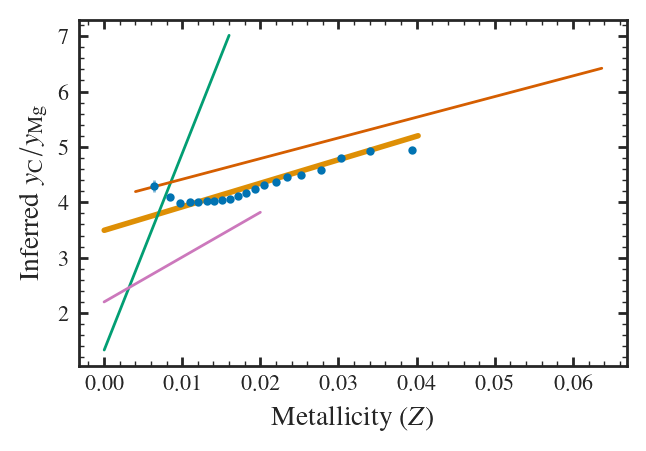

In [12]:
plt.figure(figsize=(10/3, 10/3/np.sqrt(2)))
# parameters

y_c = co_to_yc(c_o)
y_c_err = y_c * np.log(10) * c_o_err

Z = MH_to_Z(MoverH)
a,b,c = plt.errorbar(Z, y_c/y_mg_cc, y_c_err/y_mg_cc, fmt="o", capsize=0, ms=2)
c[0].set_alpha(0.5)

popt, covt = curve_fit(y_mod, Z, y_c, sigma=y_c_err, p0=(0.005, 0.1))


# plt.plot(fe_h, y_agb(fe_h))
x_mod = np.linspace(-3, 0.5)
print(popt)
print(np.diag(covt)**0.5)

# plt.plot(MoverH, y_mod(MoverH, *popt))
x = np.linspace(-3, 0.4, 100)
Z = MH_to_Z(x)
plt.plot(Z, 10**-0.02*y_mod(Z, 0.029, 0.00285)/y_mg_cc, lw=2, label="model")


x = np.linspace(-3, 0, 100)
Z = MH_to_Z(x)
y = Z*0.23167215 + 0.00086663
plt.plot(Z, y/y_mg_cc)


x = np.linspace(-0.6, 0.6, 100)
Z = MH_to_Z(x)
y = 0.02431937*Z +  0.00263668
plt.plot(Z, y/y_mg_cc)

surp.yields.set_yields()
y = vice.yields.ccsne.settings["c"]
z = np.linspace(0, 0.02, 1000)
plt.plot(z, y(z)/y_mg_cc)

plt.xlabel(r"Metallicity ($Z$)")
#leg = plt.legend()
#leg.legendHandles[0].set_visible(False)
plt.ylabel(r"Inferred $y_{\rm C}/y_{\rm Mg}$")
plt.tight_layout()
plt.savefig("figures/analytic.pdf")

In [13]:
def y_mod2(x, a, b, c):
    return a + b*(x - Z_SUN)+ c*(x-Z_SUN)**2

[0.00270344 0.01997399 0.25989582]
[1.51061778e-05 2.81367824e-03 1.66638324e-01]


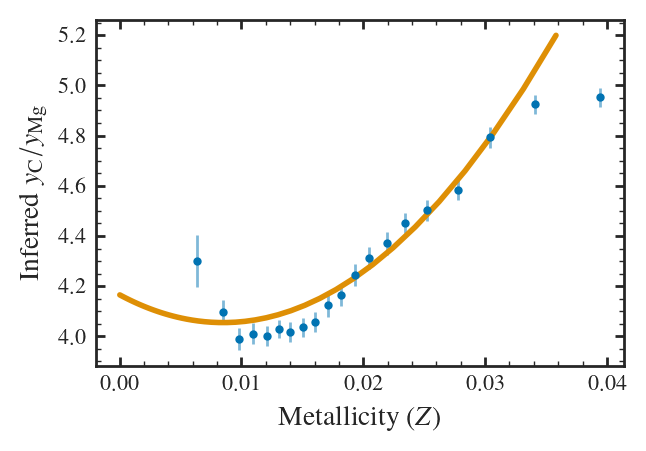

In [14]:
plt.figure(figsize=(10/3, 10/3/np.sqrt(2)))
# parameters

y_c = co_to_yc(c_o)
y_c_err = y_c * np.log(10) * c_o_err

Z = MH_to_Z(MoverH)
a,b,c = plt.errorbar(Z, y_c/y_mg_cc, y_c_err/y_mg_cc, fmt="o", capsize=0, ms=2)
c[0].set_alpha(0.5)

chop = 3
popt, covt = curve_fit(y_mod2, Z, y_c, sigma=y_c_err, p0=(0.003, 0.1, 1))


# plt.plot(fe_h, y_agb(fe_h))
x_mod = np.linspace(-3, 0.5)
print(popt)
print(np.diag(covt)**0.5)

# plt.plot(MoverH, y_mod(MoverH, *popt))
x = np.linspace(-3, 0.35, 100)
Z = MH_to_Z(x)
#plt.plot(Z, 10**-0.04*y_mod2(Z, 2.77e-3, 0.025, 1.15)/y_mg_cc, lw=2, label="model")
plt.plot(Z, y_mod2(Z, 0.0027, 0.015, 1)/y_mg_cc, lw=2, label="model")

#plt.plot(Z, surp.yields.y_c_total(Z)/y_mg_cc*10**-0.02, lw=2)

plt.xlabel(r"Metallicity ($Z$)")
#leg = plt.legend()
#leg.legendHandles[0].set_visible(False)
plt.ylabel(r"Inferred $y_{\rm C}/y_{\rm Mg}$")
plt.tight_layout()
plt.savefig("figures/analytic.pdf")

[0.00270344 0.01997399 0.25989562]
[1.51061769e-05 2.81367844e-03 1.66638351e-01]
yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 5.28e-02 (Z-Z0),    1.36 × cristallo11             0                              
                    Z>=-1.00e+00; 8.67e-04 +                                                                     
                    0.00e+00 Z, else                                                                             

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0      

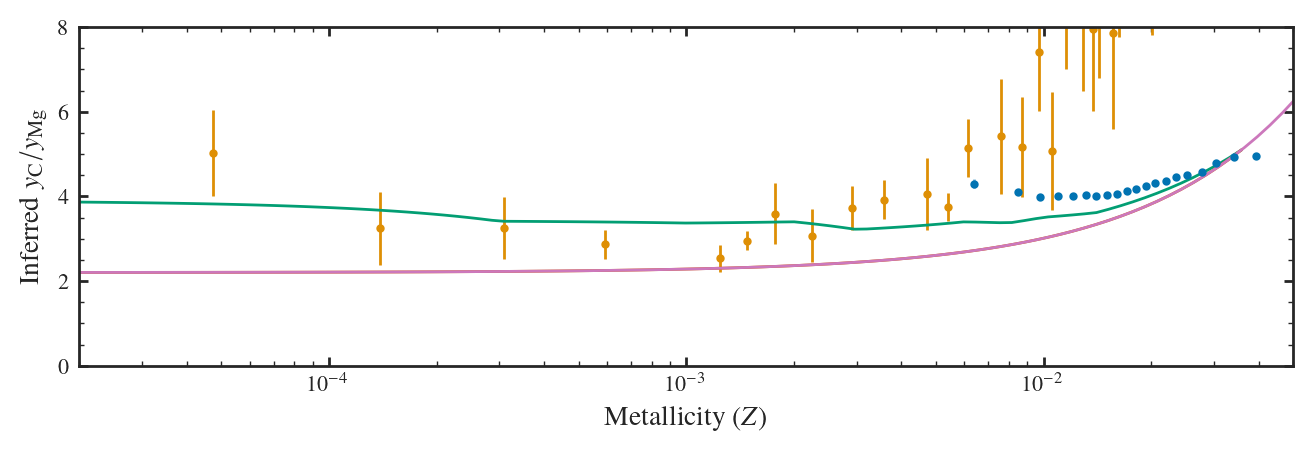

In [22]:
plt.figure(figsize=(20/3, 10/3/np.sqrt(2)))
# parameters
Z = MH_to_Z(MoverH)


y_c = co_to_yc(c_o)
y_c_err = y_c * np.log(10) * c_o_err

Z = MH_to_Z(MoverH)
a,b,c = plt.errorbar(Z, y_c/y_mg_cc, y_c_err/y_mg_cc, fmt="o", capsize=0, ms=2)
c[0].set_alpha(0.5)

popt, covt = curve_fit(y_mod2, Z, y_c, sigma=y_c_err, p0=(0.005, 0.05, 1))


print(popt)
print(np.diag(covt)**0.5)

x = np.linspace(-3, 0.35, 100)
Z = MH_to_Z(x)


y_c_a = y_o_cc*gcem.brak_to_abund(c_o_a, "C", "O")
y_err_a = y_c_a * np.log(10) * c_o_err_a

a,b,c = plt.errorbar(MH_to_Z(MoverH_a), y_c_a/y_mg_cc, y_err_a/y_mg_cc, fmt="o", capsize=0, ms=2)

#plt.plot([0, 0.004], [1.25, 1.25])

 
# y_c = co_to_yc(dwarf_all.C_MG)
# z = MH_to_Z(dwarf_all.MG_H)
# plt.scatter(z, y_c/y_mg_cc)

# y_c = co_to_yc(DLA_all.C_MG)
# z = MH_to_Z(DLA_all.MG_H)
# plt.scatter(z, y_c/y_mg_cc)

# y_c = co_to_yc(dwarf_all.C_MG)
# z = MH_to_Z(dwarf_all.MG_H)
# plt.scatter(z, y_c/y_mg_cc)

# y_c = co_to_yc(RL_all.C_MG)
# z = MH_to_Z(RL_all.MG_H)
# plt.scatter(z, y_c/y_mg_cc)

#plt.plot(Z, yyy(Z), lw=2, label="model")

mass_yields = []
for z in Z:
    vice.yields.ccsne.settings["c"] = 0
    vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c")
    m_c, times = vice.single_stellar_population("c", Z=z)
    mass_yields.append(m_c[-1]/1e6/y_mg_cc)

def y_mod3(Z):
    return 0.5*(gcem.Z_to_MH(Z) + 1.5)**2 + 26*(Z-gcem.Z_SUN)+ 1.75

surp.yields.set_yields(f_agb=0.2)

y_mod3 = lambda Z: vice.yields.ccsne.settings["c"](Z) /y_mg_cc
mass_yields = np.array(mass_yields)
y_tot = y_mod3(Z) + mass_yields

plt.plot(Z, y_tot*10**-0.02, label="total")
# plt.plot(Z,  mass_yields, lw=2, label="model")

plt.plot(Z, y_mod3(Z))



surp.yields.set_yields(f_agb=0.2)
y_mod3 = lambda Z: vice.yields.ccsne.settings["c"](Z) /y_mg_cc
Z = gcem.MH_to_Z(np.linspace(-3, 0.5, 100))
#plt.plot(Z, y_mod(Z, 0.05, 0.0027*0.8)/y_mg_cc*10**-0.02)


plt.plot(Z, y_mod3(Z))

plt.xlabel(r"Metallicity ($Z$)")
plt.xlim(2e-5, 0.05)
plt.ylim(0, 8)
plt.ylabel(r"Inferred $y_{\rm C}/y_{\rm Mg}$")
plt.xscale("log")
#plt.xscale("asinh", linear_width=0.001)
#plt.gca().xaxis.set_minor_locator(mpl.ticker.AsinhLocator(0.0001, subs=(2,4,6,8)))
#plt.xticks([0, 1e-4,1e-3, 1e-2])


plt.tight_layout()

cristallo11
y0 = (3.750196 +- 0.353110) x 10^-4
zeta0 = (-2.158182 +- 0.386261) x 10^-2
alpha = (1.519921 +- 0.143112)


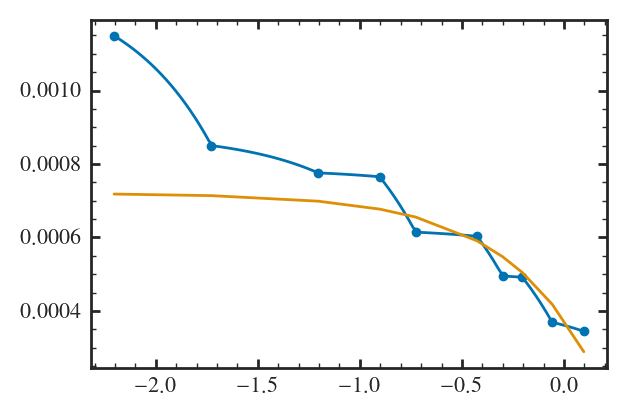

ventura13
y0 = (4.291061 +- 1.635295) x 10^-4
zeta0 = (-3.159405 +- 1.165692) x 10^-2
alpha = (1.328343 +- 0.506223)


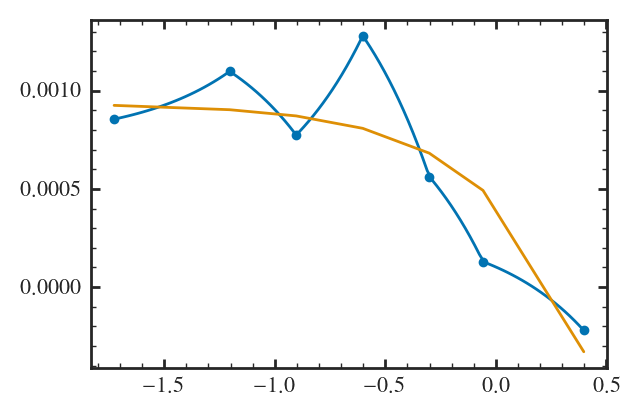

karakas16
y0 = (4.899764 +- 0.569091) x 10^-4
zeta0 = (-3.447077 +- 0.533447) x 10^-2
alpha = (1.163321 +- 0.135116)


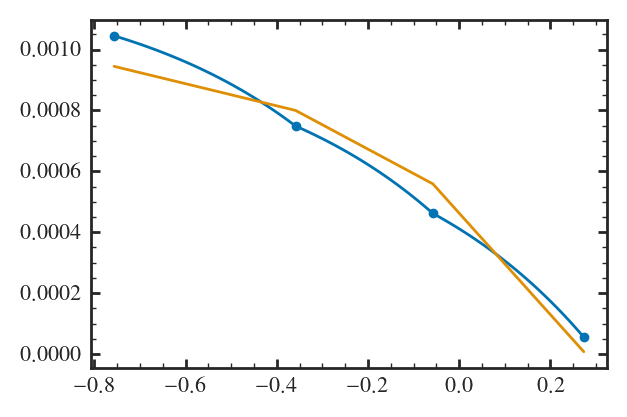

special
pignatari16
y0 = (7.375369 +- 0.325099) x 10^-4
zeta0 = (-0.928136 +- 0.275234) x 10^-2
alpha = (0.772843 +- 0.034066)


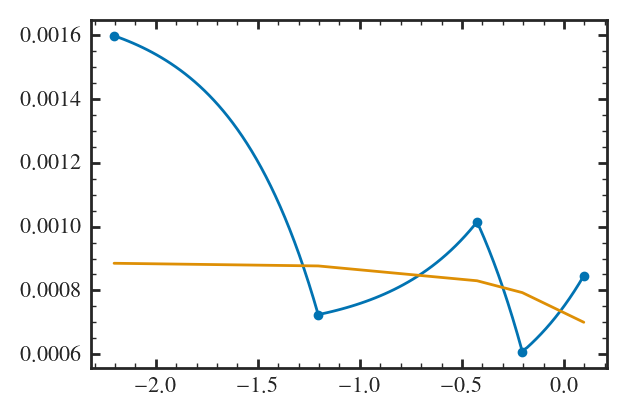

In [25]:
for study in surp._globals.AGB_MODELS:
    y1, m1, z1 = vice.yields.agb.grid("c", study=study)
    y_c_agb1 = []
    for i in range(len(z1)):
        def m_model(m):
            cs = interp1d([1] + list(m1) + [7], [0] + [a[i] for a in y1] + [0])
            return cs(m) * ( (m > 1.3) & (m < 6))
        norm = quad(lambda m: m*vice.imf.kroupa(m), 0.08, 120)[0]
        yc = quad(lambda m: m*m_model(m)* vice.imf.kroupa(m), 1.3, 6)[0]/norm
        y_c_agb1.append(yc)

    mh1 = Z_to_MH(z1)
    y_c_agb1 = np.array(y_c_agb1)

    y_agb = lambda x: interp1d(z1, y_c_agb1, fill_value="extrapolate")(MH_to_Z(x))

    mh_mod = np.linspace(min(mh1), max(mh1), 100)
    y_agb_mod = y_agb(mh_mod)
    
    plt.plot(mh_mod, y_agb_mod)

    plt.scatter(mh1, y_c_agb1)
    
    def lin(x, a, b):
        Z = MH_to_Z(x)
        return a + b*(Z-Z_SUN) + 0*1.07*(Z-Z_SUN)**2
    

    if study == "pignatari16":
        print("special")
        filt = mh_mod > -1.5
        popt, covt = curve_fit(lin, mh_mod[filt], y_agb_mod[filt])
    else:
        filt = mh1 > -1
        popt, covt = curve_fit(lin, mh1[filt], y_c_agb1[filt])

    plt.plot(mh1, lin(mh1, *popt))

    print(study)
    errs = np.diag(np.sqrt(covt))
    print(f"y0 = ({popt[0]*1e4:3f} +- {errs[0]*1e4:3f}) x 10^-4")
    print(f"zeta0 = ({popt[1]*1e2:3f} +- {errs[1]*1e2:3f}) x 10^-2")
    alpha = surp.yields.Y_C_0 * 0.2 / popt[0]
    alpha_err = alpha * errs[0]/popt[0]

    
    print(f"alpha = ({alpha:3f} +- {alpha_err:3f})")

    #plt.xlim(-1)
    plt.show()
    

In [26]:
β = 7e-4
def y_agb_n(monh):
    return β*10**monh


y_cc_n0 = 9e-4

In [27]:
def mod_n(x, a, b):
    return a + b*10**x

NameError: name 'n_o' is not defined

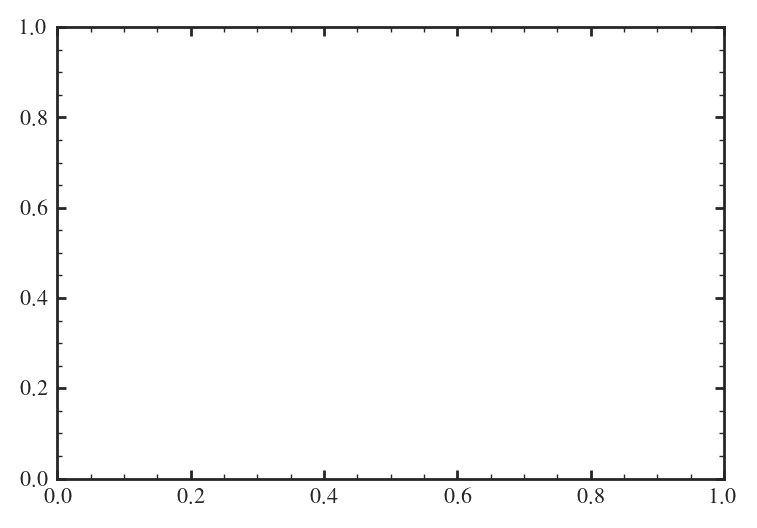

In [28]:
# parameters
sp = arya.Subplot()
y_o_cc = 0.015

y_n = y_o_cc*gcem.brak_to_abund(n_o, "N", "O")
y_n_err = y_n * np.log(10) * n_o_err

y_n_cc = y_n 
a,b,c = plt.errorbar(MoverH, y_n_cc, y_n_err, fmt="o", capsize=0, ms=2)

c[0].set_alpha(0.5)

# plt.scatter(all_dat["[o/h]"], all_dat.y_c, s=1)

popt, covt = curve_fit(mod_n, MoverH, y_n_cc)
 
plt.plot(MoverH, y_agb_n(MoverH)+y_cc_n0, lw=2)

# plt.plot(MoverH, mod_n(MoverH, *popt), zorder=4, lw=2)
plt.xlabel("[Mg/H]")
plt.ylabel(r"$y_{\rm N}^{\rm CC}$")
sp.save("analytic_n.pdf")

In [29]:
print(popt)

[ 0.00073754 -0.00928136]


In [30]:
for i in range(len(z1)):
    
    def m_model(m):
        cs = CubicSpline([1] + list(m1) + [7], [0] + [a[i] for a in y1] + [0])
        return cs(m) * ( (m > 1) & (m < 7))
        
    x = np.linspace(1.3, 6, 1000)
    y =m_model(x)
    plt.plot(x, y)
    plt.scatter(m1, [a[i] for a in y1])

NameError: name 'CubicSpline' is not defined

In [18]:
y_c_agb1 = []
for i in range(len(z1)):
    def m_model(m):
        cs = interp1d([1] + list(m1) + [7], [0] + [a[i] for a in y1] + [0])
        return cs(m) * ( (m > 1.3) & (m < 6))
    norm = quad(lambda m: m*vice.imf.kroupa(m), 0.08, 120)[0]
    yc = quad(lambda m: m*m_model(m)* vice.imf.kroupa(m), 1.3, 6)[0]/norm
    y_c_agb1.append(yc)

[-0.00031826  0.00042053]
[2.56664095e-05 2.58029024e-05]


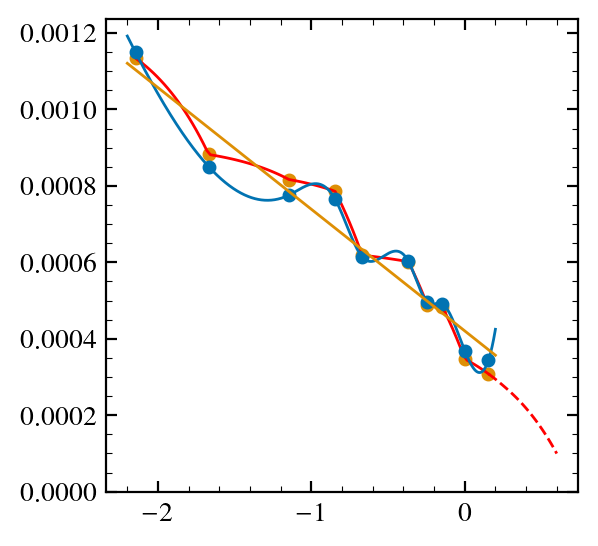

In [19]:
mh1 = np.log10(np.array(z1)/0.014)

cs = CubicSpline(mh1, y_c_agb1)
sp = arya.Subplot()

plt.scatter(mh1, y_c_agb1)

def yc_agb(z):
    return cs(z)
x = np.linspace(-2.2, 0.2, 1000)

def lin(x, a, b):
    return a*x + b

popt, covt = curve_fit(lin, mh1, y_c_agb1)
plt.plot(x, yc_agb(x))
plt.plot(x, lin(x, *popt))
plt.ylim(0)
print(popt)
print(np.diag(covt)**0.5)





vice.yields.agb.settings["c"] = "cristallo11"
vice.yields.ccsne.settings["c"] = 0
Zs = 0.014*10**np.linspace(-2, 1, 100)
model = "cristallo11"
    
    # plots importaint points
y1, m1, z1 = vice.yields.agb.grid('c', study=model)
Zs = np.array(z1)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
        
y_c_agb = np.array(mass_yields)/1e6 
y_o_cc = 0.015
arya.Scatter(np.log10(Zs/0.014), y_c_agb, subplot=sp, zorder=4-i)
    
    
MoverH_min = np.log10(min(Zs)/0.014)
MoverH_max = np.log10(max(Zs)/0.014)
    
Zs = 0.014*10**np.linspace(MoverH_min, MoverH_max, 100)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])

l = arya.Line(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), 
              subplot=sp, zorder=4-i, color="red")

Zs = 0.014*10**np.linspace(-2.1, MoverH_min, 100)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
arya.Line(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", 
          color=l.color, subplot=sp, zorder=4-i)

Zs = 0.014*10**np.linspace(MoverH_max, 0.6, 100)
mass_yields = []
for Z in Zs:
    m_c, times = vice.single_stellar_population("c", Z=Z)
    mass_yields.append(m_c[-1])
arya.Line(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", 
          color=l.color, subplot=sp, zorder=4-i)

0.0001
0.0003
0.001
0.002
0.003
0.006
0.008
0.01
0.014
0.02


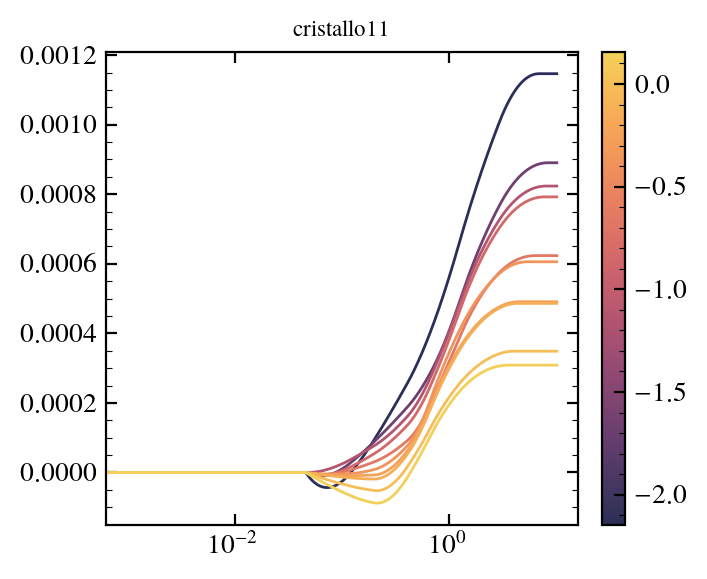

0.0001
0.004
0.008
0.02


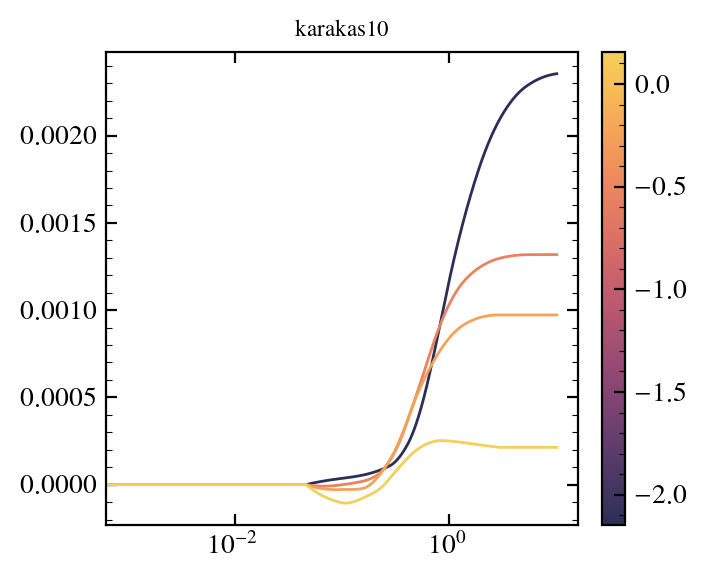

0.0003
0.001
0.002
0.004
0.008
0.014
0.04


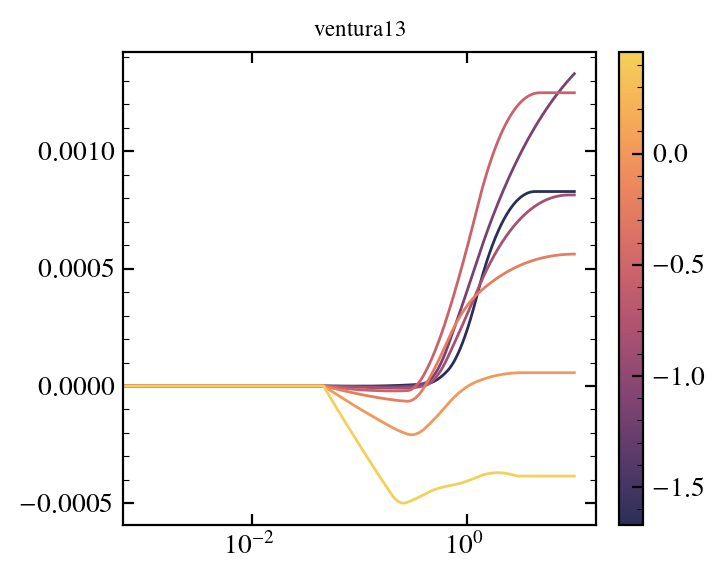

0.0028
0.007
0.014
0.03


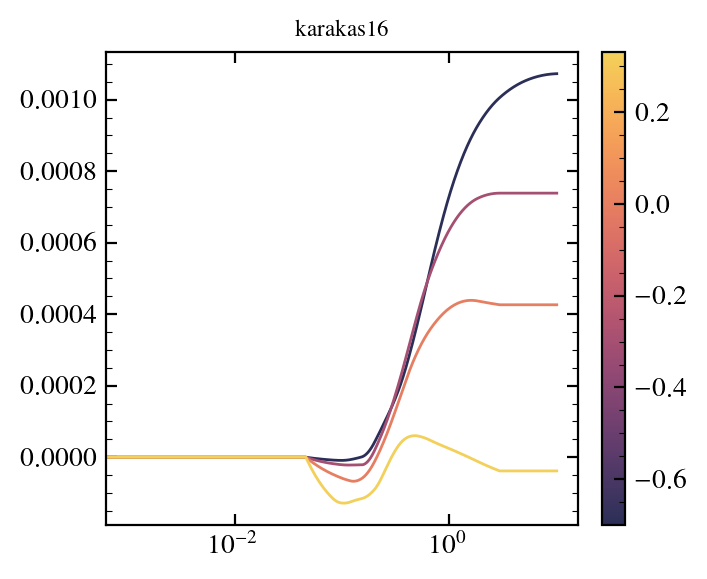

In [27]:
vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
cmap = arya.style.get_cmap()



model = "cristallo11"

for model in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
    _, _, z1 = vice.yields.agb.grid("c", model)
    logZ_min = np.log10(min(z1)/0.014)
    logZ_max = np.log10(max(z1)/0.014)

    norm = mpl.colors.Normalize(logZ_min, logZ_max)

    mpp = mpl.cm.ScalarMappable(norm, cmap)
    ma = mpp.to_rgba

    sp = arya.Subplot()
    plt.title(model)

    plt.xscale("log")
    cmap = arya.style.get_cmap()
    for i in range(len(z1)):
        z = z1[i]
        vice.yields.agb.settings["c"] = model
        m_c, times = vice.single_stellar_population("c", Z=z, dt=1e-3)
        m_c = [c for c in m_c]
        print(z)

        l = arya.Line(times, np.array(m_c)/1e6, color=ma(np.log10(z/0.014)), subplot=sp)



    arya.Colorbar(subplot=sp, mappable=mpp)
    plt.show()

0.0001
0.0003
0.001
0.002
0.003
0.006
0.008
0.01
0.014
0.02


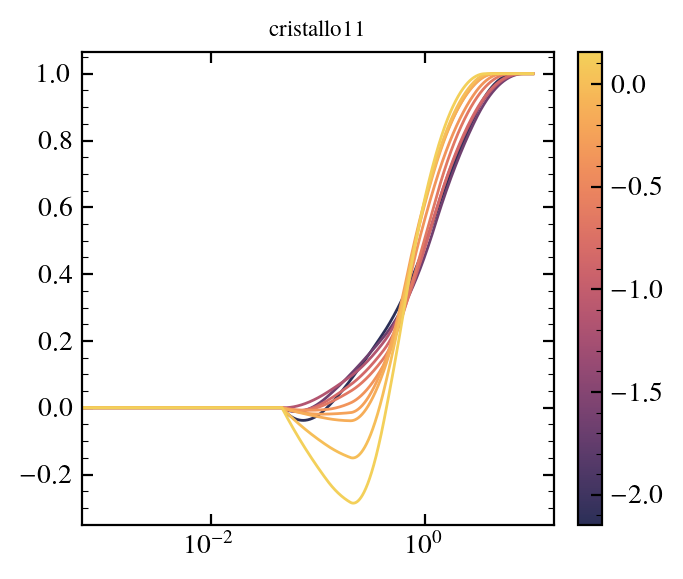

0.0001
0.004
0.008
0.02


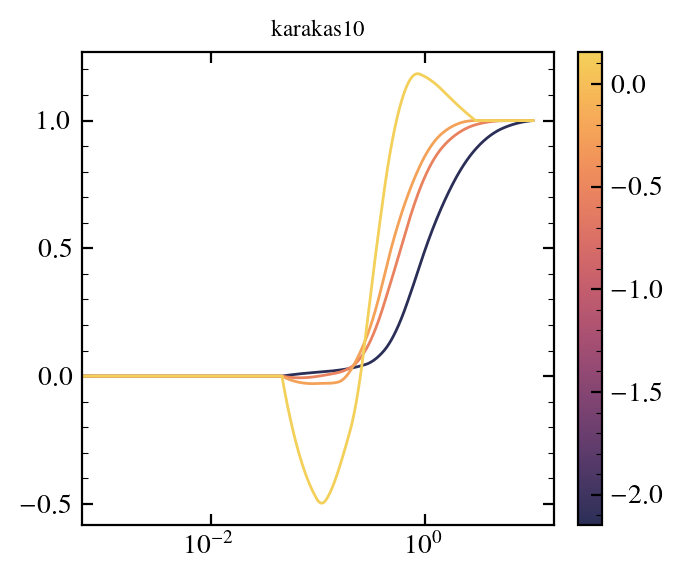

0.0003
0.001
0.002
0.004
0.008
0.014
0.04


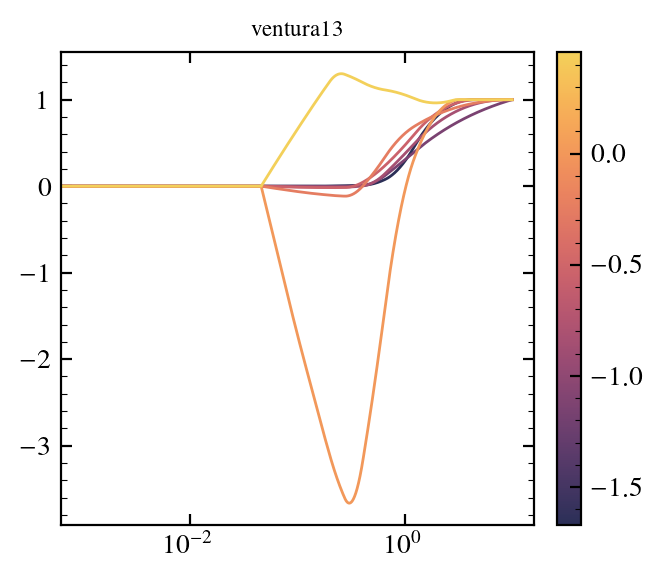

0.0028
0.007
0.014
0.03


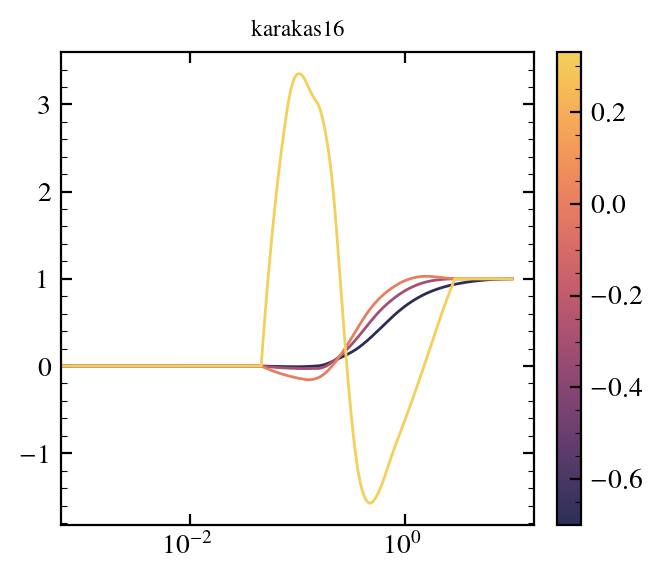

In [26]:
vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
cmap = arya.style.get_cmap()



model = "cristallo11"

for model in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
    _, _, z1 = vice.yields.agb.grid("c", model)
    logZ_min = np.log10(min(z1)/0.014)
    logZ_max = np.log10(max(z1)/0.014)

    norm = mpl.colors.Normalize(logZ_min, logZ_max)

    mpp = mpl.cm.ScalarMappable(norm, cmap)
    ma = mpp.to_rgba

    sp = arya.Subplot()
    plt.title(model)

    plt.xscale("log")
    cmap = arya.style.get_cmap()
    for i in range(len(z1)):
        z = z1[i]
        vice.yields.agb.settings["c"] = model
        m_c, times = vice.single_stellar_population("c", Z=z, dt=1e-3)
        m_c = [c for c in m_c]
        print(z)

        l = arya.Line(times, np.array(m_c)/m_c[-1], color=ma(np.log10(z/0.014)), subplot=sp)



    arya.Colorbar(subplot=sp, mappable=mpp)
    plt.show()

In [ ]:
def y_agb(MoverH):
    return vice.ya

In [38]:
def calc_y_c_cc(y_agb_a, y_o_cc=0.015):
    y_c_cc =y_o_cc*gcem.brak_to_abund(c_o[filt], "C", "O") - y_agb_a[filt]
    y_c_cc_err = y_c_cc * c_o_err[filt] * np.log(10)
    return y_c_cc, y_c_cc_err

In [23]:
def plot_model(y_agb_a, **kwargs):
    y_c_cc, _ = calc_y_c_cc(y_agb_a)
    plt.plot(MoverH[filt], y_c_cc, **kwargs)

In [24]:
def compare_y_c_cc(y_agb_a):
    plot_model(y_agb_a)
    y_c_cc_model = fit_model(y_agb_a)(Z[filt])
    plt.errorbar(MoverH[filt], y_c_cc_model)

    plt.xlabel("[M/H]")
    plt.ylabel("y carbon core collapse")

Above, solid lines are the fitted curves and the squigly lines are the value of y_c_cc calculated at each \[M/H\]

In [27]:
def plot_f_agb(y_agb_a):
    y_c_cc, _ = calc_y_c_cc(y_agb_a)
    plt.plot(MoverH[filt], y_agb_a[filt]/(y_c_cc+y_agb_a[filt]))

In [28]:
def compare_f_agb(y_agb_a):
    plot_f_agb(y_agb_a)

    plt.xlabel("[M/H]")
    plt.ylabel("f agb")
    plt.scatter(0, 0.2, marker="*", s=200, c="orange")
    #plt.ylim(-1)


0.003763657973465769
model: y_c^cc = (0.0038 +- 0.00008) + (0.007 +- 0.0002})*Z
one file saved at ./analytic.pdf


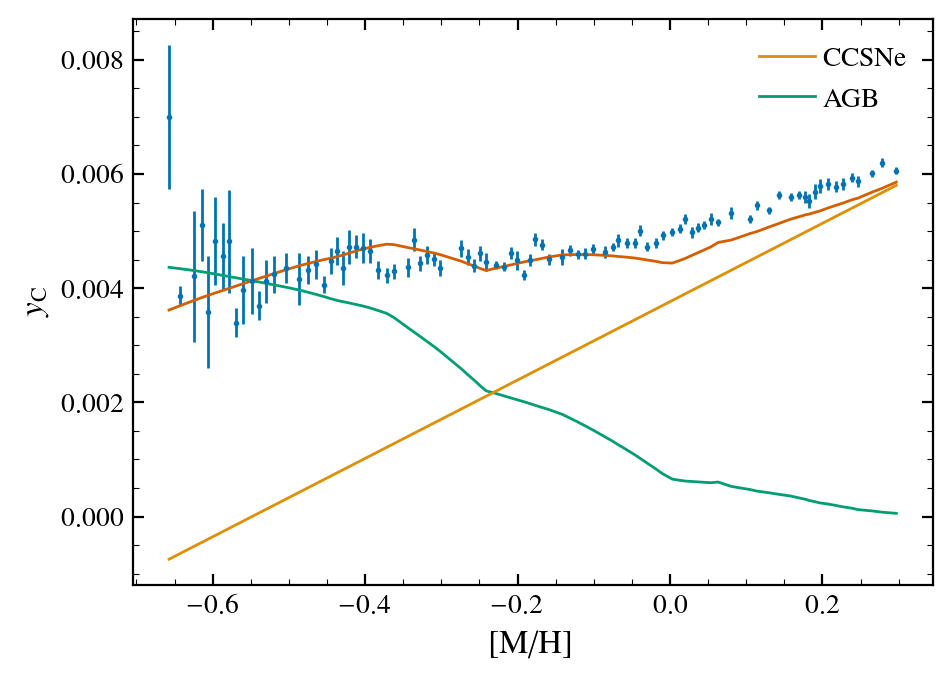

In [47]:

yagb = y_agb_a["cristallo11"] * 3

# fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plt.sca(axs[0])
y_c, y_c_err = calc_y_c_cc(0*yagb)

sp = arya.Subplot()
y_c_cc, y_c_cc_err = calc_y_c_cc(yagb)
plt.errorbar(MoverH[filt], y_c, yerr=y_c_err, fmt="o", ms=1, capsize=0)
y_c_cc_model = fit_model(yagb)(Z[filt])
plt.plot(MoverH[filt], y_c_cc_model, zorder=3, label="CCSNe")
plt.plot(MoverH[filt], yagb[filt], label="AGB")
plt.plot(MoverH[filt], yagb[filt] + y_c_cc_model)

plt.xlabel("[M/H]")
plt.ylabel(r"$y_{\rm C}$")
plt.legend()


# plt.sca(axs[1])

# plt.plot(*calc_equlibrium(yagb), label="1", lw=3, color="red")

# plt.scatter(df["FE_H"], df["C_O"], s=1, color="k")
# plt.xlabel("[O/H]")
# plt.ylabel("[C/O]")
# plt.xlim(-0.7, 0.6)
# plt.ylim(-0.6, 0.5)


# plt.tight_layout()


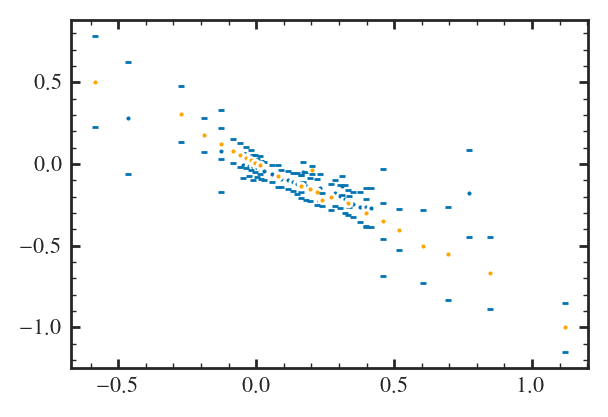

In [17]:
arya.binnedplot(subgiants, x="MG_FE", y="C_MG")
arya.binnedplot(subgiants, x="O_FE", y="C_O", facecolor="orange")

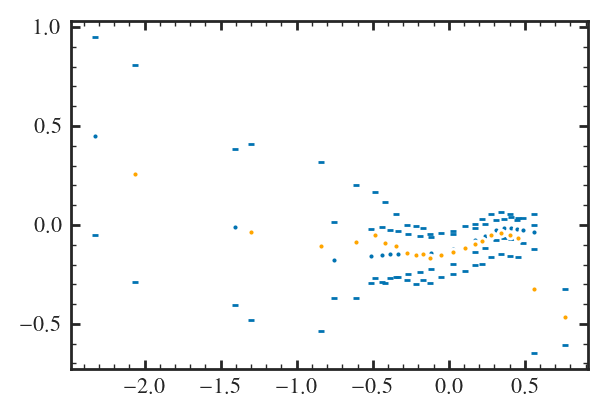

In [18]:
arya.binnedplot(subgiants, x="MG_H", y="C_MG")
arya.binnedplot(subgiants, x="O_H", y="C_O", facecolor="orange")